In [1]:
import pandas as pd
import torch
import spacy
from transformers import BertTokenizer, BertForTokenClassification
import re
import string


In [ ]:
df=pd.read_csv('C:/Pc/Nlp Test/newdata.csv')

In [ ]:
def preprocess_data(text, max_length=1000):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and punctuation
    text = re.sub(r'[{}]'.format(string.punctuation), ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    

    
    # Implement any other preprocessing steps you need
    
    return text
df['Preprocessed_Text'] = df['cleaned_transcript'].apply(preprocess_data)

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, BertConfig
from concurrent.futures import ThreadPoolExecutor
import psutil  # For memory usage monitoring
import spacy

# Load your DataFrame with transcripts
data = df

# Load BERT tokenizer and pre-trained NER model
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
print("BERT tokenizer loaded.")

# Load BERT configuration
config = BertConfig.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

# Load the BERT model for token classification
model = BertForTokenClassification(config)
model.eval()  # Set the model to evaluation mode

# Move the model to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define batch size and maximum allowed memory usage (in GB)
batch_size = 4  # Experiment with this value
max_memory_usage = 8  # Adjust this based on your system's available RAM

# Load the spaCy model
nlp_spacy = spacy.load("en_core_web_sm")
ruler = nlp_spacy.add_pipe("entity_ruler")

# Define financial metric patterns
financial_metric_patterns = [
    [{"LOWER": "current"}, {"LOWER": "ratio"}],
    [{"LOWER": "gross"}, {"LOWER": "margin"}],
    [{"LOWER": "net"}, {"LOWER": "burn"}],
    [{"LOWER": "net"}, {"LOWER": "profit"}],
    [{"LOWER": "revenue"}],
    [{"LOWER": "earnings"}],
    [{"LOWER": "profit"}],
    [{"LOWER": "annual"}, {"LOWER": "recurring"}, {"LOWER": "revenue"}],
    [{"LOWER": "cac"}, {"LOWER": "payback"}, {"LOWER": "period"}],
    [{"LOWER": "customer"}, {"LOWER": "lifetime"}, {"LOWER": "value"}],
    [{"LOWER": "revenue"}, {"LOWER": "per"}, {"LOWER": "employee"}],
    [{"LOWER": "mrr"}, {"LOWER": "growth"}, {"LOWER": "rate"}]
]

# Add the financial metric patterns to the entity ruler
ruler.add_patterns([
    {"label": "FINANCIAL_METRIC", "pattern": pattern} for pattern in financial_metric_patterns
])

# Pre-tokenize and pre-encode the cleaned_transcript data
preprocessed_input = [
    tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_tensors="pt",
        padding="max_length",
        max_length=600,  # Experiment with this value
        truncation=True
    ) for text in data["Preprocessed_Text"]
]
print("Preprocessing completed.")

# Rest of your code for processing batches and extracting predicted metrics...
def process_batch(batch_input_ids, batch_attention_masks):
    entities_list = []

    for text_input_ids, text_attention_masks in zip(batch_input_ids, batch_attention_masks):
        tokens = tokenizer.convert_ids_to_tokens(text_input_ids[0].cpu().numpy())
        text = tokenizer.decode(text_input_ids[0], skip_special_tokens=True)

        doc = nlp_spacy(text)

        entities = []
        entity = ""
        for token in doc:
            if token.ent_type_ != "":
                if entity:
                    entities.append(entity)
                entity = token.text
            elif entity:
                entity += " " + token.text
        if entity:
            entities.append(entity)

        entities_list.append(entities)

    return entities_list

# Process batches using parallel processing
predicted_entities = []
 # Number of transcripts to process
with ThreadPoolExecutor(max_workers=2) as executor:  # Limit the number of parallel workers
    futures = []
    for start_idx in range(0, len(data)):
        batch_input_ids = [entry["input_ids"] for entry in preprocessed_input[start_idx:start_idx + 1]]
        batch_attention_masks = [entry["attention_mask"] for entry in preprocessed_input[start_idx:start_idx + 1]]

        futures.append(executor.submit(process_batch, batch_input_ids, batch_attention_masks))

    for future in futures:
        predicted_entities.extend(future.result())

data["predicted_metrics"] = predicted_entities

# Print the DataFrame with extracted and predicted metrics
print(data[["Preprocessed_Text", "predicted_metrics"]])


In [ ]:
data["predicted_metrics"] = predicted_entities

In [ ]:
data.to_csv('C:/Pc/Nlp Test/new output/NER.csv', index=False)

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define batch size and max sequence length
batch_size = 12  # Adjust as needed
max_seq_length = 128  # Adjust as needed

# Example encode_batch function with debugging statements
def encode_batch(batch_segments):
    encoded_batch = []
    for segment in batch_segments:
        batch_tokenized = tokenizer.encode_plus(
            segment,
            add_special_tokens=True,
            max_length=max_seq_length,
            truncation=True,
            return_tensors='pt'
        )
        print(f"Tokenized input_ids size: {batch_tokenized['input_ids'].size()}")
        with torch.no_grad():
            batch_embeddings = model(**batch_tokenized).last_hidden_state
        encoded_batch.append(batch_embeddings)
    return encoded_batch

data = pd.read_csv('C:/Pc/Nlp Test/new output/NER.csv')

encoded_embeddings = []

with ThreadPoolExecutor() as executor:
    for i in range(0, len(data), batch_size):
        batch_segments = data['Preprocessed_Text'][i:i + batch_size].tolist()
        batch_embeddings = executor.submit(encode_batch, batch_segments).result()
        encoded_embeddings.extend(batch_embeddings)

# Calculate the number of segments in the last batch
remaining_segments = len(data) % batch_size

# Process the last batch separately if there are remaining segments
if remaining_segments > 0:
    last_batch_segments = data['Preprocessed_Text'][-remaining_segments:].tolist()
    last_batch_embeddings = encode_batch(last_batch_segments)
    encoded_embeddings.extend(last_batch_embeddings)

# Concatenate tensors along dimension 0
encoded_embeddings_tensor = torch.cat(encoded_embeddings, dim=0)


In [ ]:
save_path = 'C:/Pc/Nlp Test/new output/encoded_embeddings_tensor.pt'

# Save the tensor to the specified file path
torch.save(encoded_embeddings_tensor, save_path)

In [9]:
import torch
loaded_encoded_embeddings_tensor = torch.load('C:/Pc/Nlp Test/new output/encoded_embeddings_tensor.pt')
loaded_encoded_embeddings_tensor = loaded_encoded_embeddings_tensor[:-1]

In [4]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from transformers import pipeline
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool, cpu_count
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

C:\Users\htm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


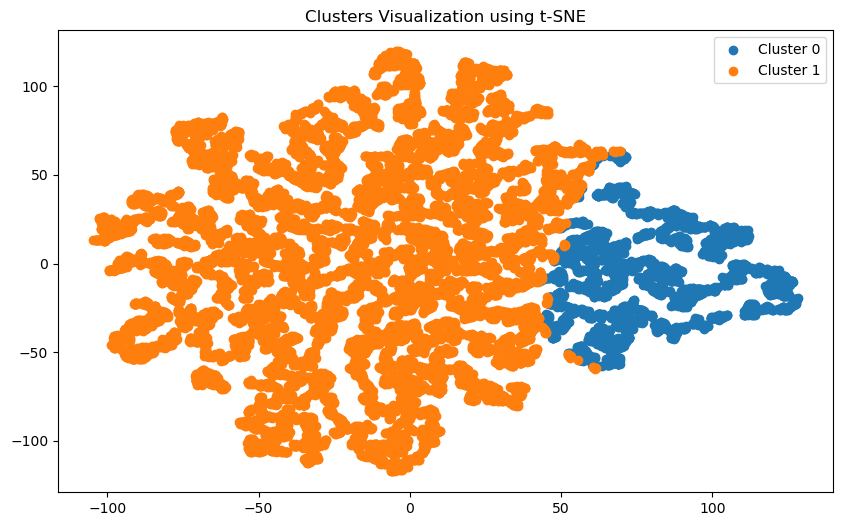

In [10]:
aggregated_embeddings = loaded_encoded_embeddings_tensor.mean(dim=1)

# Perform PCA for dimensionality reduction
n_components = 2  # You can adjust this based on your needs
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(aggregated_embeddings)

# Perform KMeans clustering
num_clusters = 2  # You can adjust this value
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(reduced_embeddings)

# Plot the clusters using different colors
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    cluster_mask = cluster_labels == cluster_id
    plt.scatter(embeddings_tsne[cluster_mask, 0], embeddings_tsne[cluster_mask, 1], label=f'Cluster {cluster_id}')
plt.title('Clusters Visualization using t-SNE')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.508777909916552


In [5]:
from multiprocessing import Pool, cpu_count
from transformers import pipeline
import pandas as pd

# Load pre-trained sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased")

# Define a mapping of sentiment labels to your "Increase" and "Decrease" labels
sentiment_mapping = {
    "LABEL_0": "Increase",
    "LABEL_1": "Neutral",
    "LABEL_2": "Decrease",
}

# Define sliding window size


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [3]:
window_size = 512

# Initialize a list to store labeled data
labeled_data = []

# Process a single transcript
def process_transcript(transcript, embeddings_tensor):
    text_length = len(transcript)
    segment_labels = []  # List to store segment sentiment labels

    # Process the text using sliding windows
    for i in range(0, text_length, window_size // 2):  # Overlap by half
        segment = transcript[i:i + window_size]

        # Get the corresponding embedding from the pre-computed tensor
        embedding_idx = len(labeled_data)
        embedding = embeddings_tensor[embedding_idx]
        embedding_list = embedding.tolist()

        sentiment_results = sentiment_analyzer(segment)
        sentiment_label = sentiment_results[0]["label"]
        mapped_label = sentiment_mapping.get(sentiment_label, "Unknown")

        segment_labels.append(mapped_label)  # Append segment label to list


# Use Colab Pro's resources for multiprocessing
batch_size = 12  # Adjust as needed
num_processes = min(cpu_count(), 2)  # You can use more if needed

# Process transcripts using parallel processing
with Pool(processes=num_processes) as pool:
    transcripts = data['Preprocessed_Text'].tolist()
    embeddings_tensor = loaded_encoded_embeddings_tensor.clone()  # Clone the tensor to avoid issues with multiprocessing
    pool.starmap(process_transcript, zip(transcripts, [loaded_encoded_embeddings_tensor]*len(transcripts)))
df_all_segment_labels = pd.DataFrame({'Segment_Labels': all_segment_labels})
df_all_segment_labels.to_csv('C:/Pc/Nlp Test/new output/segment_labels.csv', header=False, index=False)

NameError: name 'cpu_count' is not defined

In [24]:
labels=pd.read_csv('C:/Pc/Nlp Test/outputs/ensemble_labels.csv')
data=pd.read_csv('C:/Pc/Nlp Test/new output/NER.csv')

In [25]:
labels

,Cluster_Label
0,0
1,0
2,1
3,0
4,0
...,...
14999,0
15000,0
15001,0
15002,0


In [28]:


# Replace all occurrences of value 2 with value 1
labels['Cluster_Label'] = labels['Cluster_Label'].replace(2, 1)

# Now you have labels_df with values 0 and 1 instead of 2
updated_labels = labels['Cluster_Label'].tolist()

[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [30]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm  # Import tqdm for progress bars

# Load and preprocess your labeled dataset
texts = data['Preprocessed_Text'].tolist()
labels = updated_labels

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and preprocess the text data
encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)

# Load a pretrained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Prepare transcript-label pairs
transcripts = []  # List to store transcript tensors
paired_labels = []  # List to store corresponding labels

for i, encoding in tqdm(enumerate(encodings['input_ids']), total=len(encodings['input_ids']), desc='Processing Encodings'):
    if i < len(labels):
        transcripts.append((encoding, encodings['attention_mask'][i]))
        paired_labels.append(labels[i])

# Split the dataset into training and testing sets
train_pairs, test_pairs, train_labels, test_labels = train_test_split(transcripts, paired_labels, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = torch.utils.data.TensorDataset(torch.tensor([pair[0] for pair in train_pairs]),
                                              torch.tensor([pair[1] for pair in train_pairs]),
                                              torch.tensor(train_labels))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor([pair[0] for pair in test_pairs]),
                                             torch.tensor([pair[1] for pair in test_pairs]),
                                             torch.tensor(test_labels))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training and evaluation code (similar to previous example)
# ...

# After training and evaluating, you can use the trained model for prediction
# ...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\htm\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Processing Encodings: 100%|██████████████████████████████████████████████████| 18755/18755 [00:00<00:00, 854813.06it/s]


In [23]:
type(labels)

list

In [31]:
# Evaluation code
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
test_correct = 0
total_batches = len(test_loader)

with tqdm(total=total_batches, desc='Testing', unit='batch') as pbar:
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        with torch.no_grad():  # No gradient calculation during evaluation
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss
            loss = criterion(logits, labels)

            # Accumulate loss
            test_loss += loss.item()

            # Calculate number of correct predictions
            predictions = logits.argmax(dim=1)
            test_correct += (predictions == labels).sum().item()

        pbar.update(1)

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
accuracy = test_correct / len(test_dataset)

print(f'Test Loss: {avg_test_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')


Testing: 100%|████████████████████████████████████████████████████████████████████| 188/188 [09:06<00:00,  2.91s/batch]

Test Loss: 0.6860
Accuracy: 58.65%
